## Preparations

In [1]:
import pandas as pd
import numpy as np
import sqlite3


In [2]:
with sqlite3.connect("../laliga.sqlite") as con:
    df = pd.read_sql_query("SELECT * from Matches", con)


First, we need to extract the result and the goals of each match similar to the beginning of the exercises.

In [3]:
def get_result(score: str):
    if score is None:
        return None
    goals = list(map(int, score.split(":")))
    if goals[0] > goals[1]:
        return "1"
    elif goals[1] > goals[0]:
        return "2"
    else:
        return "X"


In [4]:
df["result"] = df["score"].apply(get_result)
df["result"] = df["result"].map(str)


In [5]:
def get_goals(score: str, home_away: int):
    if score is None:
        return None
    goals = list(map(int, score.split(":")))
    return goals[home_away]


In [6]:
df["home_goals"] = df["score"].apply(get_goals, args=(0,))
df["away_goals"] = df["score"].apply(get_goals, args=(1,))


## Feature Extraction

In this section, we extract the features we want to use from the data available. For a more detailed analysis of the possible impact of the features and their statistics, see the `FeatureAnalysis` notebook.

Our first features come from the matchday standings calculated in the analytical work, exercise 10. From there, we will use the rank of both of the teams and the goals scored and conceded on average up to that point of the season. We will also use the results of the last 5 games that we computed by computing a form number out of them: A win ist worth +1, a tie 0 and a loss -1. These values are then added up.

In [7]:
def get_form(last_5):
    if last_5 != "[]":
        last_5 = list(last_5)
        form = 0
        for result in last_5:
            if result == "W":
                form += 1
            elif result == "T":
                pass
            elif result == "L":
                form -= 1
        return form
    else:
        return None


In [8]:
df_standings = pd.read_excel("../reports/MatchdayStandings.xlsx", engine="openpyxl")
df_standings["form"] = df_standings["last_5"].map(get_form)
df_standings["GF"] /= df_standings["matchday"]
df_standings["GA"] /= df_standings["matchday"]
df_standings["matchday"] += 1


In [9]:
df_standings.rename(columns={'team': 'home_team'}, inplace=True)
df = df.merge(df_standings[['season', 'division', 'matchday', 'rank', 'home_team', 'form', 'GF', 'GA']], left_on=['season', 'division', 'matchday', 'home_team'], right_on=['season', 'division', 'matchday', 'home_team'], how='left')
df.rename(columns={'rank': 'home_rank', 'form': 'home_form', 'GF': 'home_GF_pg', 'GA': 'home_GA_pg'}, inplace=True)
df_standings.rename(columns={'home_team': 'away_team'}, inplace=True)
df = df.merge(df_standings[['season', 'division', 'matchday', 'rank', 'away_team', 'form', 'GF', 'GA']], left_on=['season', 'division', 'matchday', 'away_team'], right_on=['season', 'division', 'matchday', 'away_team'], how='left')
df.rename(columns={'rank': 'away_rank', 'form': 'away_form', 'GF': 'away_GF_pg', 'GA': 'away_GA_pg'}, inplace=True)

We also want to give the model more information about how well the home team was playing at home and vice versa, as a team might have a low overall rank in the standings but is near the top in the home table for example. For this we compute the home and away table similarly to the exercise 10 and extract the rank of the home team in the home table and the rank of the away team in the away table.

In [10]:
df_past = df.loc[df['season'] != '2021-2022'].copy()

In [11]:
dfs_home_table = []
dfs_away_table = []
for season in df_past['season'].drop_duplicates():
    for division in df_past.loc[(df_past['season']==season), 'division'].drop_duplicates():
        df_games = df_past.loc[(df_past['season']==season) & (df_past['division']==division)]
        teams = df_games['home_team'].drop_duplicates().rename('team')
        init_data = [(season, division, 0, 0, 0, 0, 0) for _ in teams]
        df_standings_home = pd.DataFrame(init_data, columns=['season', 'division', 'matchday', 'GF', 'GA', 'GD', 'Pts'], index=teams)
        df_standings_away = pd.DataFrame(init_data, columns=['season', 'division', 'matchday', 'GF', 'GA', 'GD', 'Pts'], index=teams)
        for matchday in df_games['matchday'].drop_duplicates():
            df_standings_home['matchday'] += 1
            df_standings_away['matchday'] += 1
            df_matchday = df_games.loc[df_games['matchday']==matchday]            
            for i in df_matchday.index:
                game = df_matchday.loc[i, :]
                df_standings_home.loc[game['home_team'], 'GF'] += game['home_goals']
                df_standings_home.loc[game['home_team'], 'GA'] += game['away_goals']
                df_standings_away.loc[game['away_team'], 'GF'] += game['away_goals']
                df_standings_away.loc[game['away_team'], 'GA'] += game['home_goals']                
                if game['result'] == '1':                    
                    df_standings_home.loc[game['home_team'], 'Pts'] += 3                    
                elif game['result'] == '2':                    
                    df_standings_away.loc[game['away_team'], 'Pts'] += 3
                else:                    
                    df_standings_away.loc[game['home_team'], 'Pts'] += 1
                    df_standings_away.loc[game['away_team'], 'Pts'] += 1
                    
            df_standings_home['GD'] = (df_standings_home['GF'] - df_standings_home['GA']).astype(int)
            df_standings_away['GD'] = (df_standings_away['GF'] - df_standings_away['GA']).astype(int)

            df_standings_home.sort_values(by=['Pts', 'GD', 'GF'], ascending=False, inplace=True)
            df_standings_home.reset_index(inplace=True)
            df_standings_home.insert(value=np.arange(1, len(df_standings_home)+1), loc=3, column='home_rank_HT')
            dfs_home_table.append(df_standings_home[['season', 'division', 'matchday', 'home_rank_HT', 'team']].copy())
            df_standings_home.drop(columns=['home_rank_HT'], inplace=True)
            df_standings_home.set_index(keys='team', drop=True, inplace=True)

            df_standings_away.sort_values(by=['Pts', 'GD', 'GF'], ascending=False, inplace=True)
            df_standings_away.reset_index(inplace=True)
            df_standings_away.insert(value=np.arange(1, len(df_standings_away)+1), loc=3, column='away_rank_AT')
            dfs_away_table.append(df_standings_away[['season', 'division', 'matchday', 'away_rank_AT', 'team']].copy())
            df_standings_away.drop(columns=['away_rank_AT'], inplace=True)
            df_standings_away.set_index(keys='team', drop=True, inplace=True)

all_home = pd.concat(dfs_home_table, ignore_index=True)
all_home['matchday'] += 1
all_home.rename(columns={'team': 'home_team'}, inplace=True)
all_away = pd.concat(dfs_away_table, ignore_index=True)
all_away['matchday'] += 1
all_away.rename(columns={'team': 'away_team'}, inplace=True)

In [12]:
df = df.merge(
    all_home,
    left_on=["season", "division", "matchday", "home_team"],
    right_on=["season", "division", "matchday", "home_team"],
    how="left",
)
df = df.merge(
    all_away,
    left_on=["season", "division", "matchday", "away_team"],
    right_on=["season", "division", "matchday", "away_team"],
    how="left",
)


As our last features, we will use the results of the last 3 direct confrontations. To quantify this, we subtract the number of wins for the away team from the number of wins for the home team. (This might take a while).

In [13]:
def last_confronts(row):
    a = row["season"]
    dt = df_past[
        (df_past.home_team == row.home_team)
        & (df_past.away_team == row.away_team)
        & (df_past.season < a)
    ].tail(3)
    res = dt[["result"]].values.tolist()
    a = res.count(["1"]) - res.count(["2"])
    return a


In [14]:
df["last_conf"] = df.apply(last_confronts, axis=1)


Also, we will use the season as a feature because the statistics of the match outcomes have changed a lot over the years. For example, the home win rate in the first seasons was even higher than the average one.

In [15]:
new = df["season"].str.split("-", n=1, expand=True)
df["season"] = new[0].astype(int)


We replace all cells where we have missing values (e.g. the ranks on the first matchday) by zeros, because the model will not be able to predict instances where feature values are missing.

In [16]:
df_features = df[['home_rank','away_rank','home_form','away_form','home_GF_pg',
              'home_GA_pg','away_GF_pg','away_GA_pg','home_rank_HT','away_rank_AT','last_conf']].copy()
df_features[df_features.isna()] = 0
df_features[['season','division','matchday','home_team','away_team','score','result']] = df[['season','division','matchday','home_team','away_team','score','result']].copy()
df_features = df_features[['season','division','matchday','home_team','away_team','score','result','home_rank','away_rank','home_form',
              'away_form','home_GF_pg','home_GA_pg','away_GF_pg','away_GA_pg','home_rank_HT','away_rank_AT','last_conf']]

To not execute all the feature extraction again when training the model, we save the file in a sqlite database. This allows us to select specific parts of the data (for example specific seasons) more easily than a csv format.

In [17]:
with sqlite3.connect("../laliga_features.sqlite") as con:
    df_features.to_sql("Matches", con, if_exists="replace", index=False)


## Training the Model

One of the most difficult aspects when training the model is the fact that our available dataset is very imbalanced. In the analytical exercises we have seen that over 52% of the games are a win for the home team. While training our first models, we saw that this led them to predict nearly always a home win. This resulted in a respectable accuracy of around 50%, but of course this is not a desired result.

In this section we train a few different models and look also on the precision (what percentage of games predicted to be home/tie/away actually were correctly predicted) and recall (what percentage of games that were home/tie/away were correctly predicted) of each of the classes. In the end we want to use a `VotingClassifier` that uses the results of several different classifiers which then "vote" to give their final decision. 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier


In [19]:
with sqlite3.connect("../laliga_features.sqlite") as con:
    df_final = pd.read_sql_query("SELECT * from Matches", con)

df_final["result"] = pd.Categorical(df_final["result"])
df_final = df_final[df_final["season"] < 2021]
features = [
    "season",
    "matchday",
    "home_rank",
    "away_rank",
    "home_form",
    "away_form",
    "home_GF_pg",
    "home_GA_pg",
    "away_GF_pg",
    "away_GA_pg",
    "home_rank_HT",
    "away_rank_AT",
    "last_conf",
]
X = df_final[features].copy()
y = df_final["result"].copy()


Because our features have vastly different scalings, we scale them to zero mean and unit variance.

In [20]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


To be able to test the model's behaviour on unseen data after training, we split our dataset in train- and test data.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=20
)


### KNN Classifier

We first train a k-nearest-neighbours classifier. To determine the best number of parameters, we use a grid search. The `weights=distance` option weighs the vote of the neighbours by their distance to the sample concerned, which improves the robustness to the class imbalance.

In [22]:
param_grid = {"n_neighbors": np.arange(5, 9)}
knn = KNeighborsClassifier(weights="distance")
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
knn_cv.best_params_


{'n_neighbors': 8}

In [23]:
knn_best = KNeighborsClassifier(n_neighbors=8, weights="distance")
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)
print(accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
pd.Series(y_pred_knn).value_counts(normalize=True)


0.4811816798118168
              precision    recall  f1-score   support

           1       0.56      0.74      0.64      7613
           2       0.31      0.20      0.24      3134
           X       0.28      0.18      0.22      3707

    accuracy                           0.48     14454
   macro avg       0.38      0.37      0.37     14454
weighted avg       0.44      0.48      0.45     14454



1    0.696901
X    0.166390
2    0.136710
dtype: float64

### Decision Tree Classifier

We also tested a Decision Tree Classifier. Here, we can give the argument `class_weight=balanced` which gives samples of the underrepresented classes more weight in the training to combat the class imbalance. Again, a grid search is used to find the best parameter for `max_depth`.

In [24]:
param_grid = {"max_depth": np.arange(1, 13)}

dt = DecisionTreeClassifier(random_state=20, class_weight="balanced")
dt_cv = GridSearchCV(dt, param_grid, cv=5)
dt_cv.fit(X_train, y_train)
dt_cv.best_params_


{'max_depth': 3}

In [25]:
dt = DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=20)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
pd.Series(y_pred_dt).value_counts(normalize=True)


0.45994188459941887
              precision    recall  f1-score   support

           1       0.63      0.56      0.59      7613
           2       0.31      0.35      0.33      3134
           X       0.30      0.34      0.32      3707

    accuracy                           0.46     14454
   macro avg       0.42      0.42      0.42     14454
weighted avg       0.48      0.46      0.47     14454



1    0.471842
X    0.283728
2    0.244431
dtype: float64

This model is closer to the correct distribution of the classes and way better precision/recall over the KNN model in the away_win- and tie class. However, the recall for the home_win class decreased significantly and also the overall accuracy is lower.

The `max_depth` of 3 also means that only 3 features are looked at when classifying a game.

### AdaBoost Classifier

In [26]:
dt = DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=10)
adb = AdaBoostClassifier(base_estimator=dt, n_estimators=400)
adb.fit(X_train, y_train)
y_pred_adb = adb.predict(X_test)
print(accuracy_score(y_test, y_pred_adb))
print(classification_report(y_test, y_pred_adb))
pd.Series(y_pred_adb).value_counts(normalize=True)


0.41787740417877406
              precision    recall  f1-score   support

           1       0.61      0.47      0.53      7613
           2       0.29      0.37      0.33      3134
           X       0.28      0.34      0.31      3707

    accuracy                           0.42     14454
   macro avg       0.39      0.40      0.39     14454
weighted avg       0.46      0.42      0.43     14454



1    0.409298
X    0.308980
2    0.281721
dtype: float64

Here, the recall scores on the underrepresented classes are better than before, but the scores on the home_win class are not as good. Also, the distribution of the predicted classes is too even.

### The final VotingClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=8, weights="distance")
dt = DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=20)
dt_2 = DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=10)
adb = AdaBoostClassifier(base_estimator=dt_2, n_estimators=400)

classifiers = [("k nearest", knn), ("Decision Tree", dt), ("Ada", adb)]

vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred_vote = vc.predict(X_test)
print(accuracy_score(y_test, y_pred_vote))
print(classification_report(y_test, y_pred_vote))
pd.Series(y_pred_vote).value_counts(normalize=True)


0.4914210599142106
              precision    recall  f1-score   support

           1       0.58      0.71      0.64      7613
           2       0.34      0.27      0.30      3134
           X       0.31      0.23      0.26      3707

    accuracy                           0.49     14454
   macro avg       0.41      0.40      0.40     14454
weighted avg       0.46      0.49      0.47     14454



1    0.642867
X    0.188252
2    0.168881
dtype: float64

This model is a mix of the ones before. It retains a bit of the KNNs good scores on the home_win class, while predicting the other ones a bit more often thanks to the other models. The overall accuracy is also quite good with nearly 50% of the games predicted correctly.

As this is a `VotingClassifier`, we can not assess the resulting feature importances directly. We could look at the importances in the respective models that form part of it, but the `KNeighborsClassifier` also does not support this kind of analysis.

## Model Behaviour

We take a look at how accurate the model predicts matches depending on the difference in rank of the teams.

In [28]:
df_test = pd.DataFrame(scaler.inverse_transform(X_test), columns=features)
df_test["rank_diff"] = df_test["home_rank"] - df_test["away_rank"]
df_test["pred"] = y_pred_vote
df_test["correct"] = (y_test == y_pred_vote).to_numpy()


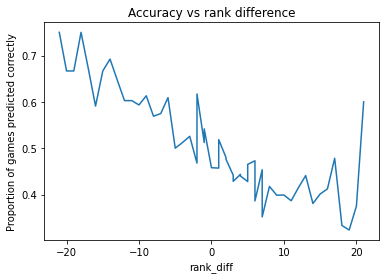

In [29]:
ax = df_test.groupby('rank_diff').mean()['correct'].plot(
    ylabel='Proportion of games predicted correctly',
    title='Accuracy vs rank difference'
    )

We see a very good accuracy when the home team is placed far better in the standings (left side of the plot), which decreases when moving towards more equal games on paper. However, the accuracy on matches where the away team has a better placement is not as good. This can be explained by the fact that our model is still overpredicting the number of home wins. However, we see a upwards trend in accuracy when looking at the matches where the away team has a far better standing.

By making this plot have one line for each correct result, we see that the model shows similar accuracy for each of the classes depending on the rank difference.

<AxesSubplot:title={'center':'Accuracy vs rank difference'}, xlabel='rank_diff', ylabel='Proportion of games predicted correctly'>

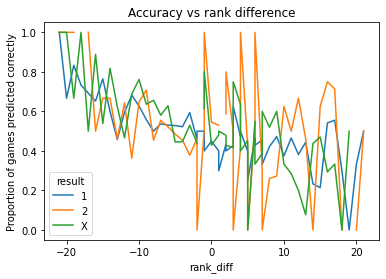

In [30]:
df_test['result'] = y_test
df_test.pivot_table(index='rank_diff', columns='result', values='correct', aggfunc=np.mean).plot.line(
    ylabel='Proportion of games predicted correctly',
    title='Accuracy vs rank difference'    
)

We also want to see how the accuracy changes over the seasons:

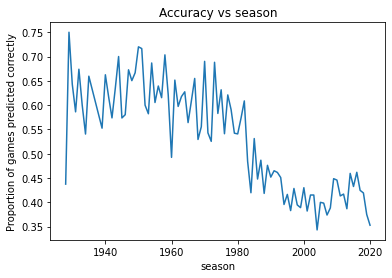

In [31]:
ax = df_test.groupby('season').mean()['correct'].plot(    
    ylabel='Proportion of games predicted correctly',
    title='Accuracy vs season'
)

Here we see that the accuracy is respectable (around 60%) for older matches but takes a significant drop around 1980. After this it is around 40-45%.

We also suspect our model behaving worse in the first matchdays of the season. There, the statistics like ranking and goals scored per game might not have as much meaning as worse teams might have had a surprisingly good start and vice versa.

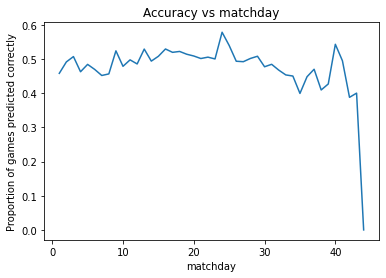

In [32]:
ax = df_test.groupby('matchday').mean()['correct'].plot(    
    ylabel='Proportion of games predicted correctly',
    title='Accuracy vs matchday'
)

We indeed see that the accuracy is better in the middle of a season than at the start. However, the accuracy also tends to decrease near the end of a season. This might be explained by the fact that these numbers of matches were only played in newer seasons after the number of teams was increased more and more over the years. Thus, games at these matchdays might not occur very often in the test set.